In [42]:
# coding: utf-8
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pylab as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cm 

#GP-UCB Code
class GPUCB(object):

  def __init__(self, meshgrid, environment, beta=100.):
    '''
    beta (optional): Hyper-parameter to tune the exploration-exploitation
    balance. If beta is large, it emphasizes the variance of the unexplored
    solution solution (i.e. larger curiosity)
    '''
    self.meshgrid = np.array(meshgrid)
    self.environment = environment
    self.beta = beta

    self.X_grid = self.meshgrid.reshape(self.meshgrid.shape[0], -1).T
    self.mu = np.array([0. for _ in range(self.X_grid.shape[0])])
    self.sigma = np.array([0.5 for _ in range(self.X_grid.shape[0])])
    self.X = []
    self.T = []
    self.parameter = 0.5
    self.sp = 0
    
  def get_y(self, P, Q, x):
    value = (x - P[0])*(Q[1] - P[1])/(Q[0]-P[0]) + P[1]
    return value


  def get_x(self, P, Q, y):
    value = (y - P[1])*(Q[0] - P[0])/(Q[1]-P[1]) + P[0]
    return value
    
        
  def argmax_ucb(self):
    return np.argmax(self.mu + self.sigma * np.sqrt(self.beta))

  def learn(self):
    grid_idx = self.argmax_ucb()
    
    if len(self.X) > 0 and self.parameter > 0:
        P = self.X[-1]
        Q = self.X_grid[grid_idx]

        if (abs(P[0]-Q[0]) >= abs(P[1]-Q[1])):
            #call function that gives y on passing x

            if P[0] < Q[0]:
                i = P[0]
                while (i + 0.25/self.parameter < Q[0]):
                    i += 0.25/self.parameter
                    j = self.get_y(P, Q, i)
                    print "Mid-way Next Sampling Location is  [",i,",",j,"]"
                    self.sample([i, j])
                    gp = GaussianProcessRegressor()
                    gp.fit(self.X, self.T)
                    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)
                    
                
            else:
                i = Q[0]
                while (i + 0.25/self.parameter < P[0]):
                    i += 0.25/self.parameter
                    j = self.get_y(P, Q, i)
                    print "Mid-way Next Sampling Location is  [",i,",",j,"]"
                    self.sample([i, j])
                    gp = GaussianProcessRegressor()
                    gp.fit(self.X, self.T)
                    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)
                    
            
            
        else:
            #call function that gives x on passing y
             if P[1] < Q[1] :
                i = P[1]
                while (i + 0.25/self.parameter < Q[1]):
                    i += 0.25/self.parameter
                    j = self.get_x(P, Q, i)
                    print "Mid-way Next Sampling Location is  [",j,",",i,"]"
                    self.sample([j, i])
                    gp = GaussianProcessRegressor()
                    gp.fit(self.X, self.T)
                    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)
                    
            
             else:
                i = Q[1]
                while (i + 0.25/self.parameter < P[1]):
                    i += 0.25/self.parameter
                    j = self.get_x(P, Q, i)
                    print "Mid-way Next Sampling Location is  [",j,",",i,"]"
                    self.sample([j, i])
                    gp = GaussianProcessRegressor()
                    gp.fit(self.X, self.T)
                    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)
                    
                
    print "Next Sampling Location is  ", self.X_grid[grid_idx]
    self.sp += 1
    self.sample(self.X_grid[grid_idx])
    gp = GaussianProcessRegressor()
    gp.fit(self.X, self.T)
    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)

  def sample(self, x):
    t = self.environment.sample(x)
    self.X.append(x)
    self.T.append(t)

  def plot(self):
    
    fig = plt.figure(figsize=(18, 8))
    fig.suptitle("Iteration %02d" %self.sp)
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
        self.mu.reshape(self.meshgrid[0].shape), alpha=0.5, color='g')
    ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
        self.environment.sample(self.meshgrid), alpha=0.5, color='b')
    ax.scatter([x[0] for x in self.X], [x[1] for x in self.X], self.T, c='r',
        marker='o', alpha=1.0)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1 = plt.subplot(122)
    ax1.pcolormesh(self.meshgrid[0], self.meshgrid[1],
        self.mu.reshape(self.meshgrid[0].shape))
  
    plt.savefig('fig_%02d.png' % len(self.X))




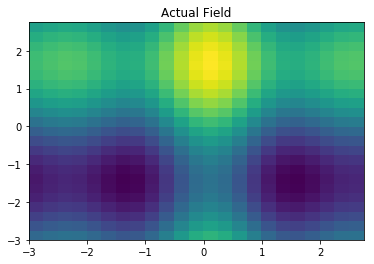

In [43]:
if __name__ == '__main__':
  class DummyEnvironment(object):
    def sample(self, j):
      return np.sinc(j[0])+np.sin(j[1])

  x = np.arange(-3, 3, 0.25)
  y = np.arange(-3, 3, 0.25)
  env = DummyEnvironment()
  agent = GPUCB(np.meshgrid(x, y), env)

  #Actual Field
  X, Y = np.meshgrid(x, y) 
  Z = np.sinc(X)+ np.sin(Y)
  #Z = np.sinc(X)+ np.sin(Y) + np.cos(X-Y)
  plt.pcolormesh(X,Y,Z)
  plt.title("Actual Field")
  
  

Next Sampling Location is   [-3. -3.]
Mid-way Next Sampling Location is  [ -2.5 , -2.5 ]
Mid-way Next Sampling Location is  [ -2.0 , -2.0 ]
Mid-way Next Sampling Location is  [ -1.5 , -1.5 ]
Mid-way Next Sampling Location is  [ -1.0 , -1.0 ]
Mid-way Next Sampling Location is  [ -0.5 , -0.5 ]
Mid-way Next Sampling Location is  [ 0.0 , 0.0 ]
Mid-way Next Sampling Location is  [ 0.5 , 0.5 ]
Mid-way Next Sampling Location is  [ 1.0 , 1.0 ]
Mid-way Next Sampling Location is  [ 1.5 , 1.5 ]
Mid-way Next Sampling Location is  [ 2.0 , 2.0 ]
Mid-way Next Sampling Location is  [ 2.5 , 2.5 ]
Next Sampling Location is   [2.75 2.75]
Mid-way Next Sampling Location is  [ 1.875 , -0.75 ]
Mid-way Next Sampling Location is  [ 2.0 , -0.25 ]
Mid-way Next Sampling Location is  [ 2.125 , 0.25 ]
Mid-way Next Sampling Location is  [ 2.25 , 0.75 ]
Mid-way Next Sampling Location is  [ 2.375 , 1.25 ]
Mid-way Next Sampling Location is  [ 2.5 , 1.75 ]
Mid-way Next Sampling Location is  [ 2.625 , 2.25 ]
Next Samplin

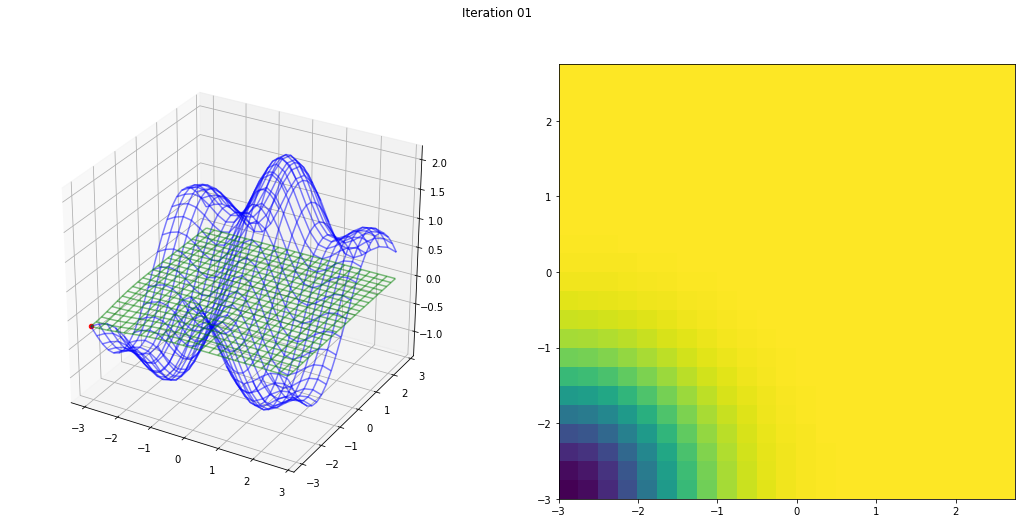

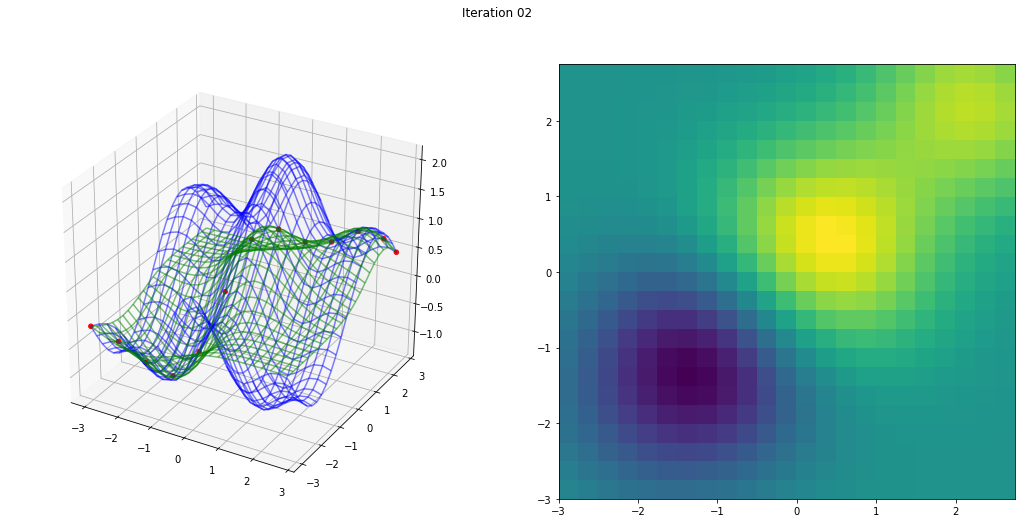

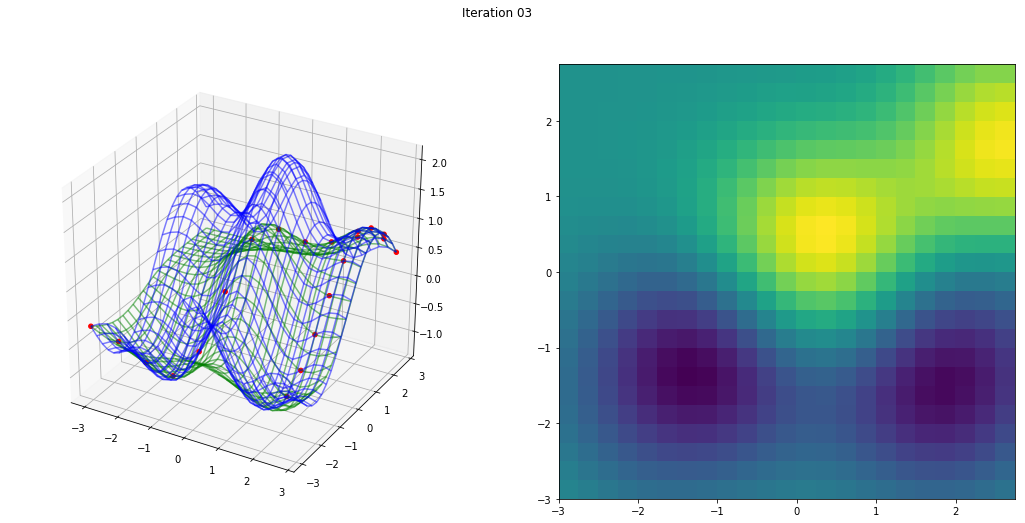

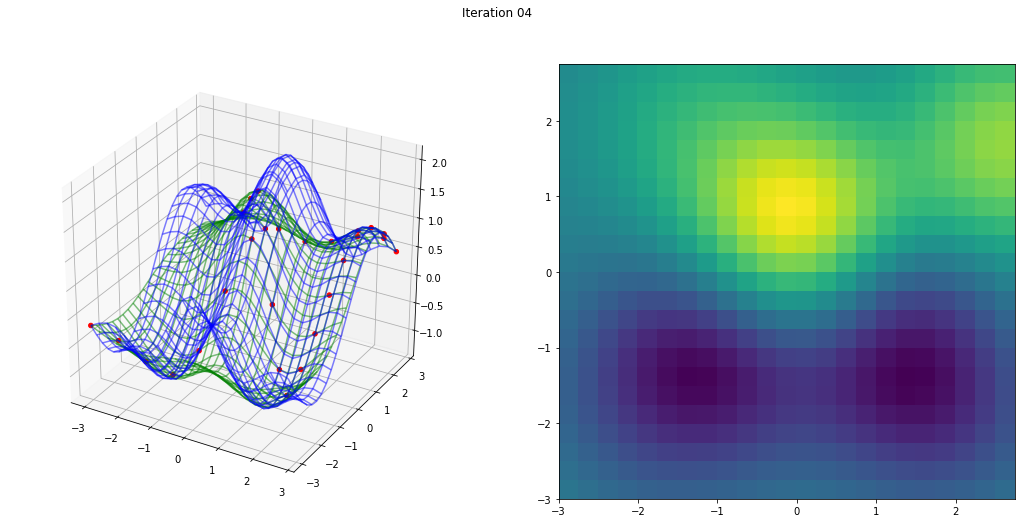

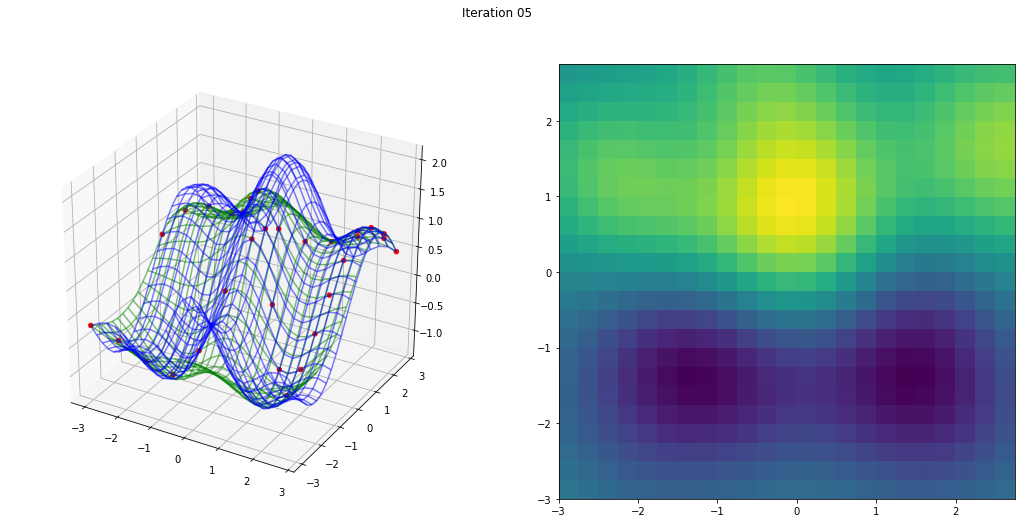

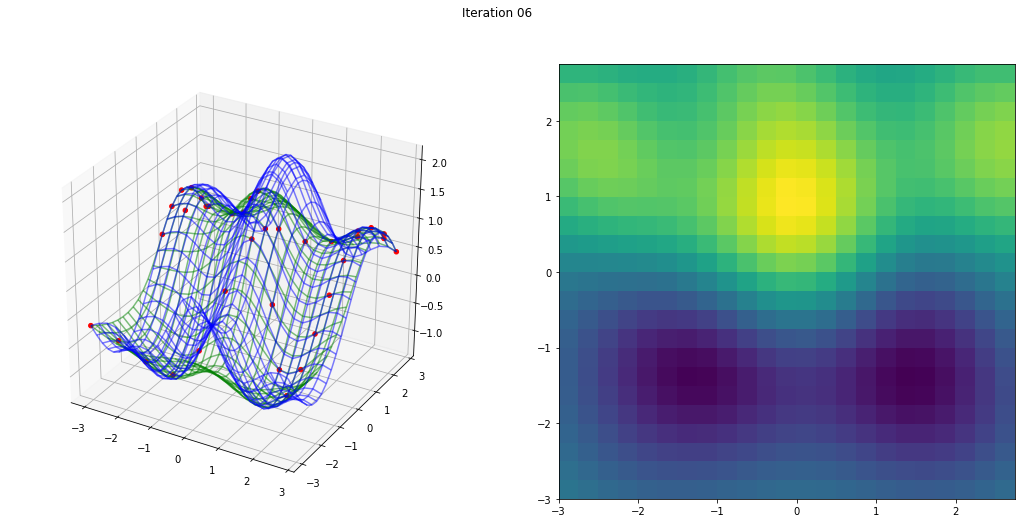

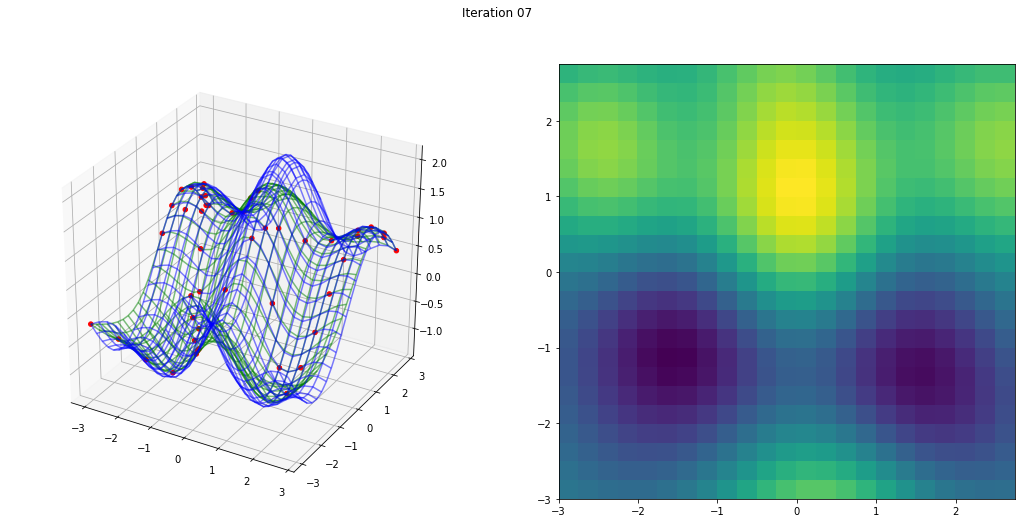

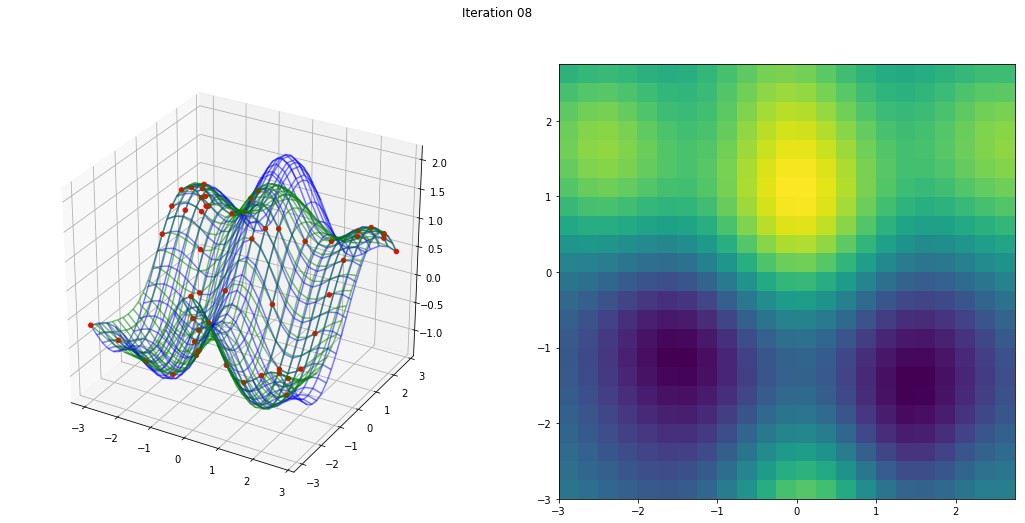

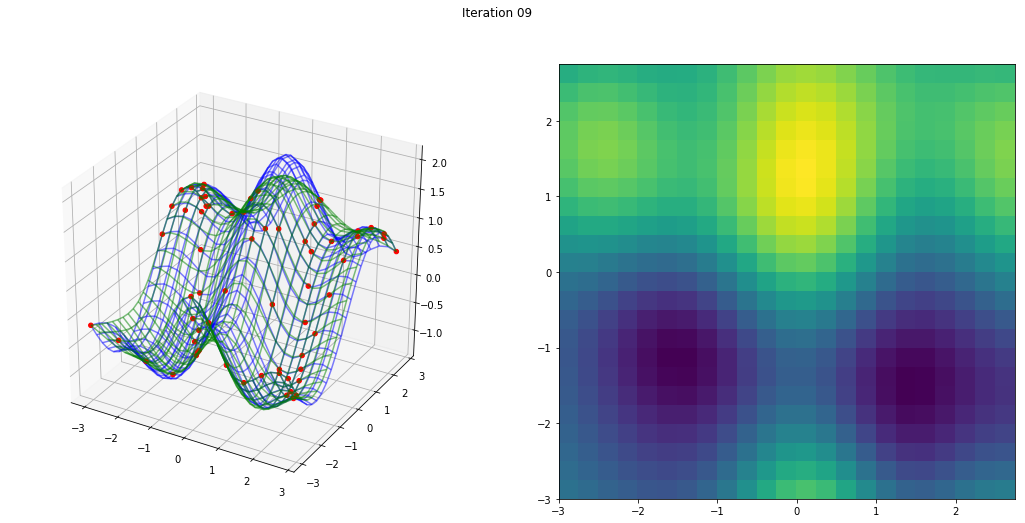

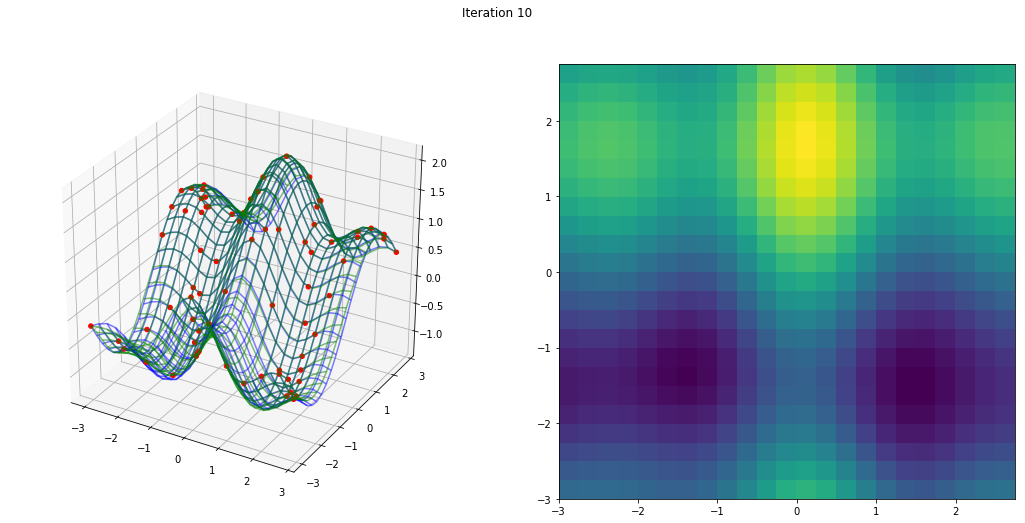

In [44]:
#Mapping the Field--
for i in range(10):
    #print "Sampling Location "+ str(i) + " is" 
    agent.learn()
    agent.plot()